# Zero to Hero with `fastai` - Intermediate
> A general overview of the major differences between the old `fastai` and the new

* toc: true
* badges: true
* comments: true

## Zero to Hero

The "Zero to Hero" series is a series of three articles geared towards getting anyone familair with the `fastai` library based upon their skill sets. The previous article is aimed towards those who have barely heard of "Deep Learning" and have zero experience with frameworks. This article article comes from a perspective of those who utilized the original fastai library in the past and understand the broad strokes of the library. Finally, the last article will briefly explain the advanced artifacts inside of `fastai` and how they all function. 
> Note: These articles also presume you have read the previous to avoid redundancy, please read it before continuing so some context can be gathered [here](https://muellerzr.github.io/fastblog/2020/08/20/_08_21-beginner.html)

## Who am I

My name is Zach Mueller, I've extensively been involved and using fastai (and the newest version) for the better part of two years now. I've designed my own course geared around the library from an implementation standpoint without getting too complex. At the time of writing this I'm still an Undergraduate at the University of West Florida majoring in Computer Science. I'm also heavily involved inside the [fastai community](forums.fast.ai), of which I would emplore you to join! My goal is to make fastai more approachable at all levels through examples and help further Jeremy's dream in the process. My specific interests involve [speeding up the framework for deployment](https://github.com/muellerzr/fastinference), tabular neural networks, and providing overall usage guides to help further the community

## What will we cover in this article?

In the second iteration of "Zero to Hero" we will be going through the major differences between the two API's. We will look more in detail at the high-level `DataBlock` API with a 1:1 code example to learn how to adjust your code from the old `fastai`. Afterwards we will look into the Mid-level API and transforms briefly to see how simple it can be to customize and adapt what you want into the framework through two seperate examples. Finally will then go into customizing test sets to include labelled and non-labelled data.

## Installing the library

First let's install `fastai`:

In [1]:
!pip install fastai -qqq

     |████████████████████████████████| 184kB 4.7MB/s 


## What's new?

Let's first look at two sets of code for a Tabular task, specifically Adult Sample
> Note: Some code cells may have `# DO NOT RUN`. Do not run these if you choose to open this notebook in Colaboratory as they reference the old codebase and will not work anymore

As per usual, we'll import the tabular library and use `untar_data` to grab the dataset:

In [2]:
from fastai.tabular.all import *

In [3]:
path = untar_data(URLs.ADULT_SAMPLE)

Then we will open the `DataFrame` in pandas:

In [4]:
df = pd.read_csv(path/'adult.csv')

In [5]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In both versions we still need to define our variables and procs, and the naming for each has not changed:

In [6]:
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [FillMissing, Categorify, Normalize]

However what *did* change was the API. Before our code would have looked like so:

In [ ]:
# DO NOT RUN
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(800,1000)))
                           .label_from_df(cols=dep_var)
                           .databunch())

Where we specify our API to have a `TabularList`, then split that list, label the list, and finally `DataBunch` it. This is gone, or at least simplified in the new version. Instead we have **TabularPandas**, a complete rework of the tabular API, which is different from the normal API. First we have special `Splitter` classes that we can call and use depending on our task. Since we are splitting by a list of indicies, it would make sense to utilize the `IndexSplitter` class. To utilize it we'll instantate the class with our list of indicies to split by, and then split our dataset via *it's* indicies. To explore more of these splitters, see the [documentation](https://docs.fast.ai/data.transforms#Split).

In [7]:
splits = IndexSplitter(list(range(800,1000)))(range_of(df)); splits

((#32361) [0,1,2,3,4,5,6,7,8,9...],
 (#200) [800,801,802,803,804,805,806,807,808,809...])

Then we can pass everything to `TabularPandas`:

In [8]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names='salary', splits=splits)

> Something very unique and nice about `TabularPandas` is we can actually use it in more than just `fastai`! 
To see how we can utilize it with Random Forests and XGBoost, see my [course notebook](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Tabular%20Notebooks/02_Ensembling.ipynb) where this is discussed

And now we can build our `DataLoaders`:

In [9]:
dls = to.dataloaders(bs=512)

From here, the API remains the same. We have a `tabular_learner` and we can `fit`, `fit_one_cycle`, etc. One minor change is now to find the learning rate, it's just `lr_find`:

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.0030199517495930195)

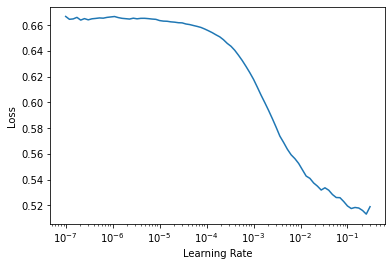

In [32]:
learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)
learn.lr_find()

Where it will also return the two suggested learning rates seen at the top of the graph. 

## A Text Example

The next major upgrade is the Text API. This is a true example of the High-Level DataBlock API discussed in the previous article. It follows the same overall pattern we saw in `TabularPandas`, just a bit more split-up. Let's take this example from my slides:

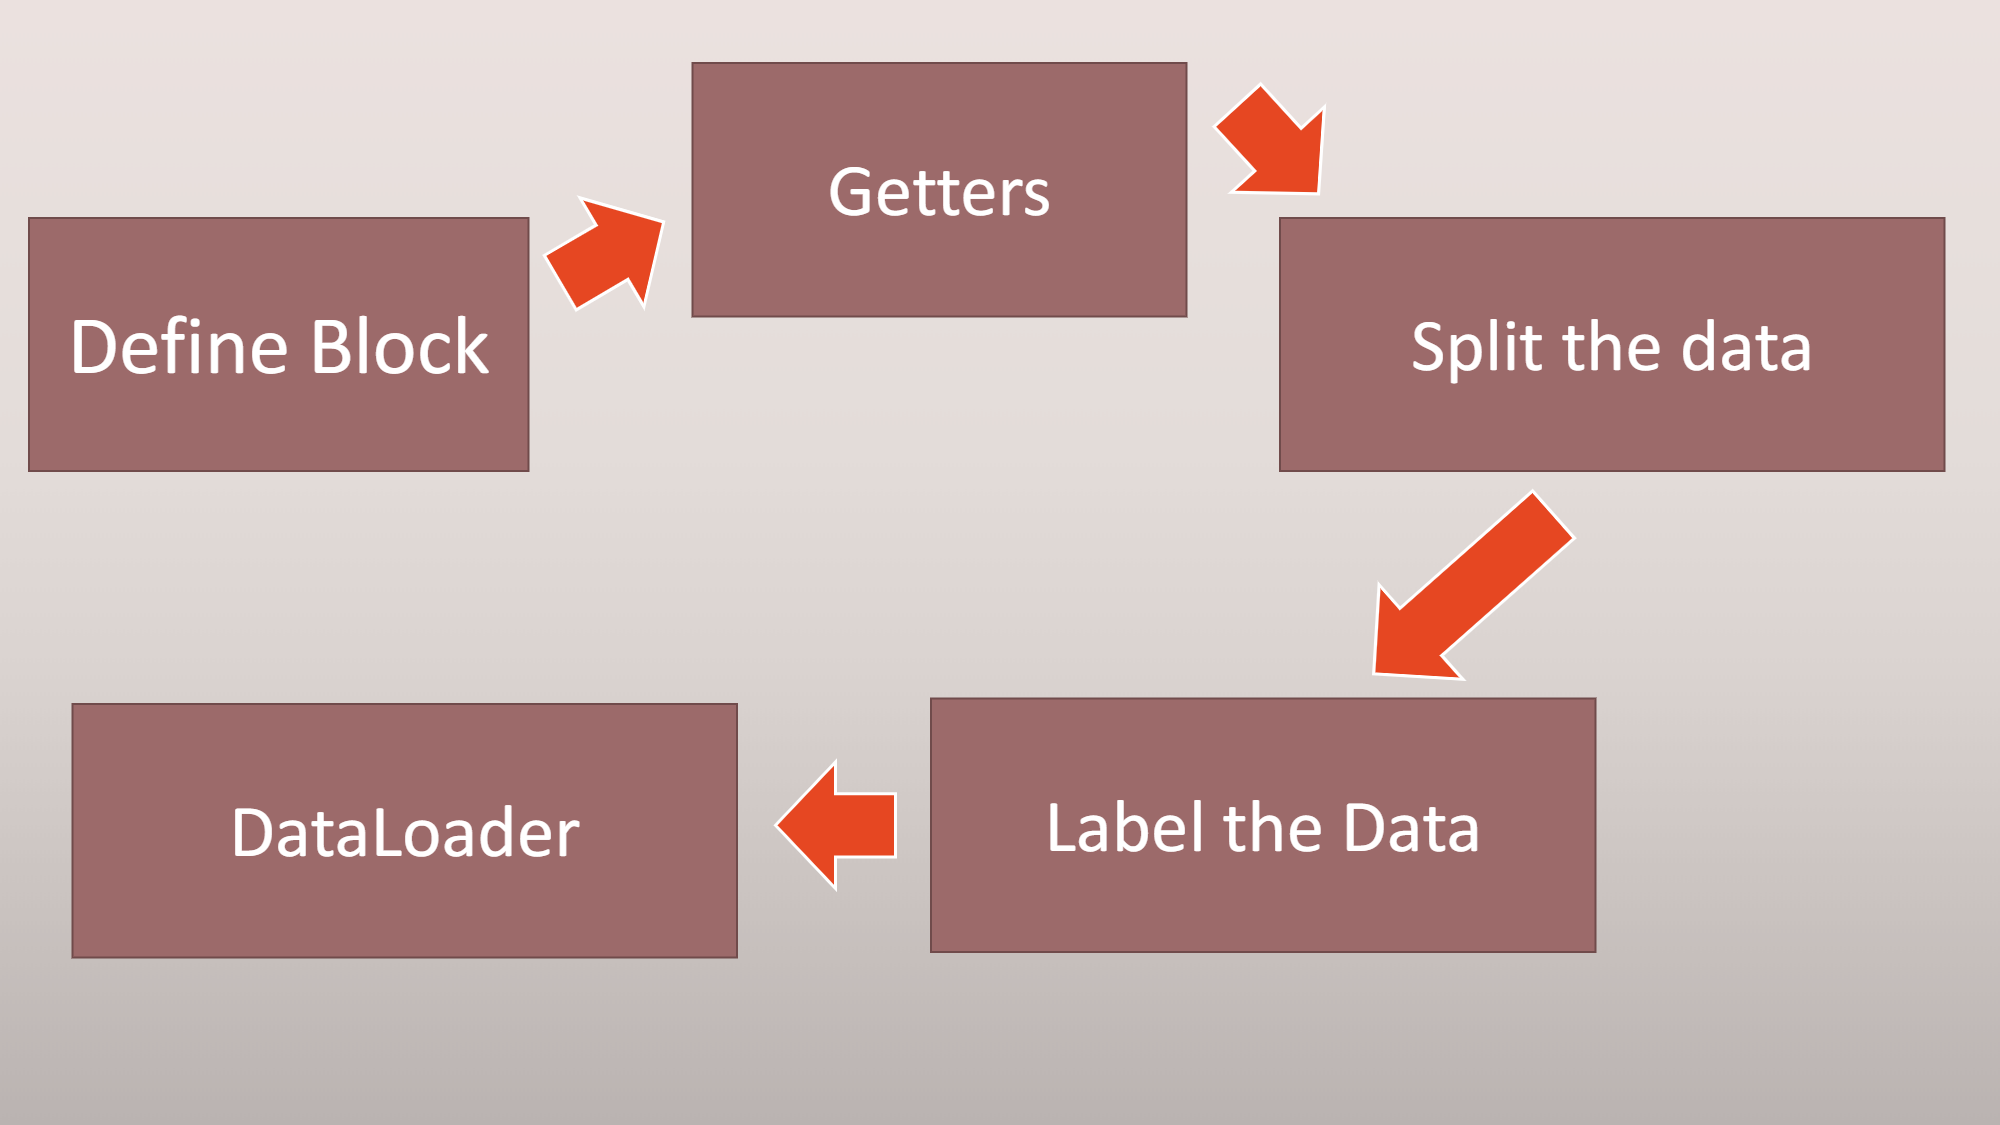

We'll run through this example step by step with a text example with `IMDB_SAMPLE`. Let's load the library and grab our data:

In [72]:
from fastai.text.all import *

In [96]:
path_imdb = untar_data(URLs.IMDB_SAMPLE)

In [76]:
df_imdb = pd.read_csv(path_imdb/'texts.csv')

In the first version of `fastai`, to build our language model `DataLoader` it would look something like below:

In [ ]:
# DO NOT RUN
data = (TextList.from_csv(path, 'texts.csv', cols='text')
       .split_by_rand_pct(0.1)
       .label_for_lm()
       .databunch(bs=8))

Now let's convert this to the new API following our pipeline description above

1. Define your input and output blocks:


  Here we have text as an input, so we simply say we have a `TextBlock.from_df` as have a `DataFrame`
  > Note: text is a bit different in this regard as things get tokenized when generating the `Dataset`. As a result, we have `.from_df` and `.from_folder`, specifying where the data comes from:

In [79]:
blocks = TextBlock.from_df(text_cols='text', res_col_name='text', is_lm=True)

Now an important distinction here is when tokenized, we will get rid of `text_cols` in our `DataFrame` and it will be replaced with `res_col_name`. This is `text` by default. Finally we want to specify that it is a language model by passing `is_lm=True`.

2. Define our getters

Now we need to tell `fastai` how to grab the data. Our text will be stored in a **column** named **text**, so we will use a `ColReader` to grab it:

In [82]:
get_x = ColReader('text')

3. Split the Data

We'll use another splitter like we did for tabular, this time using `RandomSplitter`. When calling our `DataBlock` we won't need to pass in the direct indicies, `fastai` will do this for us, so we can define it as below:

In [80]:
splitter = RandomSplitter(valid_pct=0.2, seed=42)

4. Label the Data

We have already done this by specifying `is_lm` to `True` back when we defined our blocks. When we examine a non-language model classification example next you will be able to understand the difference

5. Build the `DataLoaders`

Now let's build our `DataBlock` by passing in what we have:

In [84]:
dblock = DataBlock(blocks=blocks,
                   get_x=get_x,
                   splitter=splitter)

And we can build our `DataLoaders`:

In [87]:
dls = dblock.dataloaders(df_imdb, bs=8)

Let's look at an example batch:

In [89]:
dls.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj with its companion piece xxup masters xxup of xxup horror , xxup nightmares xxup and xxup xxunk can only be seen as the absolute xxunk of the genre that began so xxunk with xxup the xxup twilight xxup zone and xxup the xxup outer xxup limits . \n\n xxmaj of course , part of the problem is that it does nothing to be of any interest to a xxunk adult","xxmaj with its companion piece xxup masters xxup of xxup horror , xxup nightmares xxup and xxup xxunk can only be seen as the absolute xxunk of the genre that began so xxunk with xxup the xxup twilight xxup zone and xxup the xxup outer xxup limits . \n\n xxmaj of course , part of the problem is that it does nothing to be of any interest to a xxunk adult audience"
1,"since he quickly realises ( given his stormy relationship with xxmaj clara as boss and xxunk ) that loving the person he knows through the xxunk letters might not xxunk with loving the person herself . xxmaj his description to xxmaj clara of the fictional xxmaj xxunk xxmaj xxunk ( what a name ! ) who was to become her xxunk is hilarious in the extreme , but also his way of","he quickly realises ( given his stormy relationship with xxmaj clara as boss and xxunk ) that loving the person he knows through the xxunk letters might not xxunk with loving the person herself . xxmaj his description to xxmaj clara of the fictional xxmaj xxunk xxmaj xxunk ( what a name ! ) who was to become her xxunk is hilarious in the extreme , but also his way of proving"


Now if we wanted to train, the API still looks the same, where we call `language_model_learner` and pass in our data. We won't train in this example though as that can take a bit with language models:

In [90]:
lm_learn = language_model_learner(dls, arch=AWD_LSTM, metrics=accuracy)

Now let's move onto a text *classification* example. This only requires two major changes to what we had before in our `DataBlock`: the addition of another `block` and a `get_y` to tell fastai where our label is:

In [91]:
blocks = (TextBlock.from_df(text_cols='text', res_col_name='text', is_lm=False), CategoryBlock())

We set `is_lm` to `False` (the default) and added a `CategoryBlock` telling fastai we will be dealing with a classification problem. Next we need a `get_y` to say where the label is. It's still in that same `DataFrame`, so we can use another `ColReader`:

In [92]:
get_y = ColReader('label')

Finally, we'll make a new splitter that splits from a column, as our `DataFrame` has a `is_valid` option:

In [93]:
splitter = ColSplitter(col='is_valid')

Now let's remake our `DataBlock`:

In [94]:
clas_dblock = DataBlock(blocks=blocks,
                        get_x=get_x,
                        get_y=get_y,
                        splitter=splitter)

And make some new `DataLoaders`:

In [97]:
dls = clas_dblock.dataloaders(df_imdb, bs=8)

And that's it for the text example! Now you've seen the basic building blocks and how it all works. For the final example we'll walk through the PETS dataset as we did during the previous article, and recreate it with the API

## Pets

In [19]:
from fastai.vision.all import *

Let's first grab our data:

In [20]:
path = untar_data(URLs.PETS)

We'll define our `blocks` again. This time, since we have an *image* problem we'll use an `ImageBlock` and re-use `CategoryBlock`:

In [21]:
blocks = (ImageBlock(cls=PILImage), CategoryBlock())

> Note that we can define sub-classes for blocks to use. If we were doing a black and white image problem (such as MNIST), we could define our `ImageBlock` as `ImageBlock(cls=PILImageBW)`

Next we want our `getters`. This is actually just as simple as `get_image_files`. Why? Let's look:

In [22]:
imgs = get_image_files(path/'images')

In [23]:
imgs[0]

Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_194.jpg')

Here we have a list of our images, so this is all we actually need since both our `x` and `y` are there.

Next we want to split the data. We did a random 80/20 split in the first article, so we will repeat this here using `RandomSplitter`:

In [24]:
splitter = RandomSplitter(valid_pct=0.2, seed=42)

Finally we need our labeller, which is a `RegexLabeller`:

In [25]:
get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*')

Now before we continue we need some `item` and `batch` transforms to augment our data:

In [26]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]

And finally we can work this into our `DataBlock`:

In [27]:
dblock = DataBlock(blocks=blocks,
                   get_items=get_image_files,
                   splitter=splitter,
                   get_y=get_y,
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)

Let's build our data:

In [28]:
dls = dblock.dataloaders(path/'images', bs=64)

And view some data just to be sure:

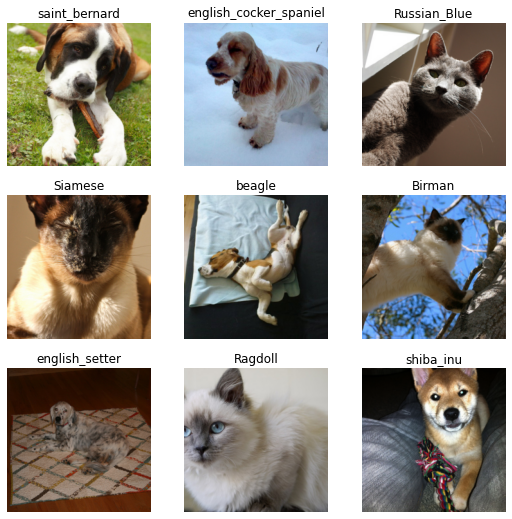

In [21]:
dls.show_batch()

We have now seen three major examples of the API from a `DataLoader` perspective. Along with this article I invite you to read my other articles related to the `DataBlock` API:

* [fastai and the New DataBlock API](https://muellerzr.github.io/fastblog/datablock/2020/03/21/DataBlockAPI.html)
* [The Idea of a Transform](https://muellerzr.github.io/fastblog/datablock/2020/03/22/TransformFunctions.html)
* [Looking at fastai's test_dl](https://muellerzr.github.io/fastblog/2020/08/10/testdl.html)

As they cover a few more specifics in regards to the API. 

## Test Sets

Now finally I mentioned the addition of labelled and non-labelled test sets. Originally back in the old fastai version when you did `add_test` for a test set and wanted it labelled you had to do [a weird workaround](https://github.com/muellerzr/fastai-Experiments-and-tips/blob/master/Test%20Set%20Generation/Labeled_Test_Set.ipynb). However this is no longer the case. With `fastai`'s `test_dl` method we can pass `with_labels=True` and it will attempt to label our data if it is labelled the same format as it were for training.

> Note: tabular problems will always assume `with_labels` to be `True` if the y is present in the `DataFrame`

Now let's first use the defaults for `test_dl` on some data:

In [29]:
dl = dls.test_dl(imgs[:10], with_labels=False)

We can look at a batch:

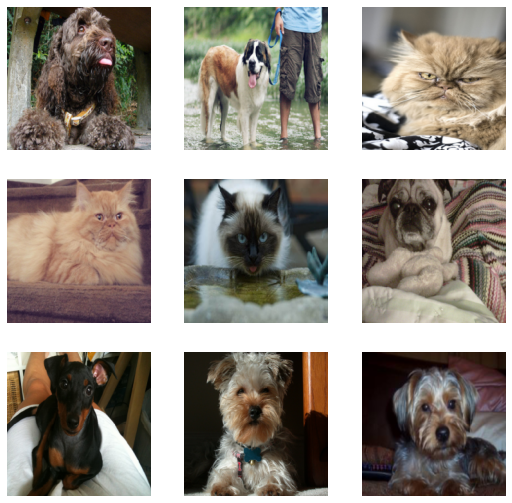

In [30]:
dl.show_batch()

And we can just see blank images! Now if we change this:

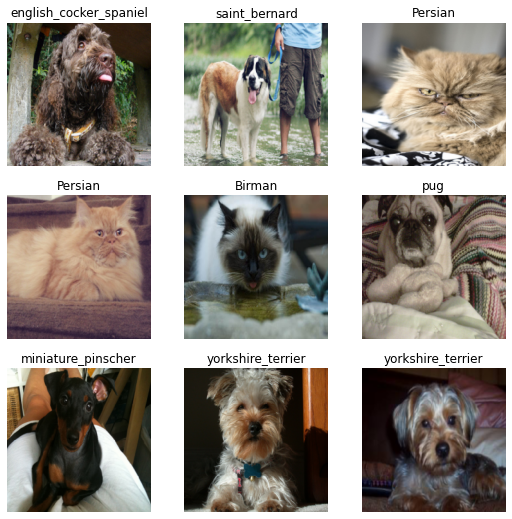

In [31]:
dl = dls.test_dl(imgs[:10], with_labels=True)
dl.show_batch()

We have our labels again! This is fantastically nice as you can then just pass this `DataLoader` into `learn.validate` by doing `learn.validate(dl=dl)` and there will be no complaints!

## Minor Changes and Closing Thoughts

Finally, let's cover some minor naming changes. 

* Passing callbacks to our `Learner` and during any `fit` are now called `cbs` rather than `callbacks`
* Callbacks have [more events](https://docs.fast.ai/callback.core#Callback) in which you are able to adjust and their naming is slightly different
* Metrics should inherit [AccuMetric](https://docs.fast.ai/metrics), but loss functions do not need this

Everything is is a major API change or difference altogether. 

Thank you so much for reading, and I implore you to check out the new library! It's been carefully crafted over the last year and a half (since the previous part 2) and has really turned into something special. These first two articles I wanted out the day of release, so part 3 will take me a few more days. Thanks again for reading and have fun exploring!